In [2]:
# Install RDKit first
!pip install rdkit-pypi

# Then install deepchem
!pip install deepchem==2.5.0

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import matplotlib.pyplot as plt
import deepchem as dc
from sklearn.metrics import accuracy_score

# Set seeds
np.random.seed(456)
tf.set_random_seed(456)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 21.7 MB/s eta 0:00:00


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [16]:
_, (train, valid, test), _ = dc.molnet.load_tox21()

train_X, train_y, train_w = train.X, train.y, train.w
valid_X, valid_y, valid_w = valid.X, valid.y, valid.w
test_X, test_y, test_w = test.X, test.y, test.w

In [4]:
# Remove extra tasks
train_y = train_y[:, 0]
valid_y = valid_y[:, 0]
test_y = test_y[:, 0]
train_w = train_w[:, 0]
valid_w = valid_w[:, 0]
test_w = test_w[:, 0]


In [5]:
# Define network parameters
d = 1024
n_hidden = 50
learning_rate = 0.001
n_epochs = 10
batch_size = 100

In [6]:
x = tf.placeholder(tf.float32, (None, d))
y = tf.placeholder(tf.float32, (None,))

In [7]:
# Hidden layer
W_hidden = tf.Variable(tf.random_normal((d, n_hidden)))
b_hidden = tf.Variable(tf.random_normal((n_hidden,)))
x_hidden = tf.nn.relu(tf.matmul(x, W_hidden) + b_hidden)

In [8]:
# Dropout layer
keep_prob = tf.placeholder(tf.float32)
x_hidden_drop = tf.nn.dropout(x_hidden, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
# Output layer
W_output = tf.Variable(tf.random_normal((n_hidden, 1)))
b_output = tf.Variable(tf.random_normal((1,)))
y_logit = tf.matmul(x_hidden_drop, W_output) + b_output
y_one_prob = tf.sigmoid(y_logit)
y_pred = tf.round(y_one_prob)

In [10]:
# Loss function
y_expand = tf.expand_dims(y, 1)
entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_logit, labels=y_expand)
loss = tf.reduce_sum(entropy)

In [11]:
# Optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [12]:
# Training loop
N = train_X.shape[0]
loss_history = []

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        pos = 0
        while pos < N:
            batch_X = train_X[pos:pos+batch_size]
            batch_y = train_y[pos:pos+batch_size]
            feed_dict = {x: batch_X, y: batch_y, keep_prob: 0.8}
            _, loss_val = sess.run([train_op, loss], feed_dict=feed_dict)
            pos += batch_size
        print("Epoch:", epoch+1, "Loss:", loss_val)
        loss_history.append(loss_val)

    # Predict on validation data
    valid_pred = sess.run(y_pred, feed_dict={x: valid_X, keep_prob: 1.0})

Epoch: 1 Loss: 181.88892
Epoch: 2 Loss: 124.87159
Epoch: 3 Loss: 137.62494
Epoch: 4 Loss: 111.88254
Epoch: 5 Loss: 118.18395
Epoch: 6 Loss: 136.77963
Epoch: 7 Loss: 153.09796
Epoch: 8 Loss: 102.934326
Epoch: 9 Loss: 49.005047
Epoch: 10 Loss: 139.643


Validation Accuracy: 0.9591315453384419


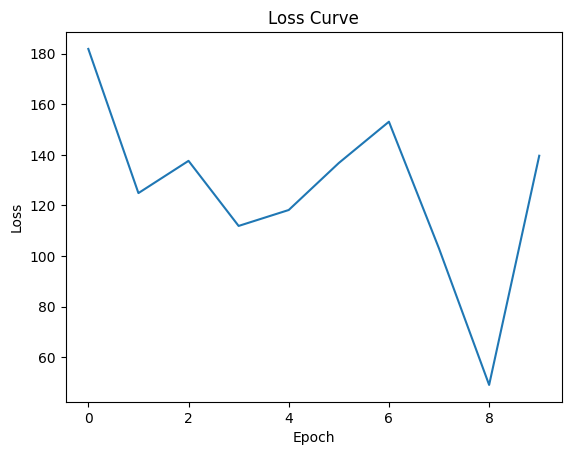

In [14]:
# Evaluate accuracy
valid_accuracy = accuracy_score(valid_y, valid_pred)
print("Validation Accuracy:", valid_accuracy)

# Plot loss curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

In [15]:

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import deepchem as dc
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

np.random.seed(456)

# Load data
_, (train, valid, test), _ = dc.molnet.load_tox21()
train_X, train_y, train_w = train.X, train.y, train.w
valid_X, valid_y, valid_w = valid.X, valid.y, valid.w
test_X, test_y, test_w = test.X, test.y, test.w

# Use only the first task
train_y = train_y[:, 0]
valid_y = valid_y[:, 0]
test_y = test_y[:, 0]
train_w = train_w[:, 0]
valid_w = valid_w[:, 0]
test_w = test_w[:, 0]

# Random Forest baseline
rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=50)
rf_model.fit(train_X, train_y)
valid_pred = rf_model.predict(valid_X)
print("Random Forest Valid Accuracy:", accuracy_score(valid_y, valid_pred, sample_weight=valid_w))

# Fully connected neural network model evaluation
def eval_model(n_hidden, n_layers, lr, dropout_prob, n_epochs=20, batch_size=100):
    d = 1024
    graph = tf.Graph()
    with graph.as_default():
        x = tf.placeholder(tf.float32, (None, d))
        y = tf.placeholder(tf.float32, (None,))
        w = tf.placeholder(tf.float32, (None,))
        keep_prob = tf.placeholder(tf.float32)
        input_layer = x

        for _ in range(n_layers):
            W = tf.Variable(tf.random_normal((d, n_hidden)))
            b = tf.Variable(tf.random_normal((n_hidden,)))
            input_layer = tf.nn.relu(tf.matmul(input_layer, W) + b)
            input_layer = tf.nn.dropout(input_layer, keep_prob)
            d = n_hidden

        W_out = tf.Variable(tf.random_normal((n_hidden, 1)))
        b_out = tf.Variable(tf.random_normal((1,)))
        y_logit = tf.matmul(input_layer, W_out) + b_out
        y_one_prob = tf.sigmoid(y_logit)
        y_pred = tf.round(y_one_prob)

        y_expand = tf.expand_dims(y, 1)
        entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_logit, labels=y_expand)
        w_expand = tf.expand_dims(w, 1)
        loss = tf.reduce_sum(w_expand * entropy)
        train_op = tf.train.AdamOptimizer(lr).minimize(loss)

        N = train_X.shape[0]
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch in range(n_epochs):
                pos = 0
                while pos < N:
                    batch_X = train_X[pos:pos+batch_size]
                    batch_y = train_y[pos:pos+batch_size]
                    batch_w = train_w[pos:pos+batch_size]
                    feed_dict = {x: batch_X, y: batch_y, w: batch_w, keep_prob: dropout_prob}
                    sess.run(train_op, feed_dict=feed_dict)
                    pos += batch_size

            valid_preds = sess.run(y_pred, feed_dict={x: valid_X, keep_prob: 1.0})
            return accuracy_score(valid_y, valid_preds, sample_weight=valid_w)

# Hyperparameter tuning
hidden_list = [50, 100]
layer_list = [1, 2]
lr_list = [0.001, 0.0005]
dropout_list = [0.3, 0.5]

best_acc = 0
best_config = None

for n_hidden in hidden_list:
    for n_layers in layer_list:
        for lr in lr_list:
            for dropout_prob in dropout_list:
                avg_acc = 0
                for repeat in range(3):  # Repeat for stability
                    acc = eval_model(n_hidden, n_layers, lr, dropout_prob)
                    avg_acc += acc
                avg_acc /= 3
                print(f"Config: hidden={n_hidden}, layers={n_layers}, lr={lr}, dropout={dropout_prob} -> Avg Val Acc: {avg_acc:.4f}")
                if avg_acc > best_acc:
                    best_acc = avg_acc
                    best_config = (n_hidden, n_layers, lr, dropout_prob)

print("Best configuration:", best_config)
print("Best average validation accuracy:", best_acc)


Random Forest Valid Accuracy: 0.6945364047432289
Config: hidden=50, layers=1, lr=0.001, dropout=0.3 -> Avg Val Acc: 0.6772
Config: hidden=50, layers=1, lr=0.001, dropout=0.5 -> Avg Val Acc: 0.6684
Config: hidden=50, layers=1, lr=0.0005, dropout=0.3 -> Avg Val Acc: 0.6733
Config: hidden=50, layers=1, lr=0.0005, dropout=0.5 -> Avg Val Acc: 0.6567
Config: hidden=50, layers=2, lr=0.001, dropout=0.3 -> Avg Val Acc: 0.6095
Config: hidden=50, layers=2, lr=0.001, dropout=0.5 -> Avg Val Acc: 0.6372
Config: hidden=50, layers=2, lr=0.0005, dropout=0.3 -> Avg Val Acc: 0.6118
Config: hidden=50, layers=2, lr=0.0005, dropout=0.5 -> Avg Val Acc: 0.6447
Config: hidden=100, layers=1, lr=0.001, dropout=0.3 -> Avg Val Acc: 0.7127
Config: hidden=100, layers=1, lr=0.001, dropout=0.5 -> Avg Val Acc: 0.6880
Config: hidden=100, layers=1, lr=0.0005, dropout=0.3 -> Avg Val Acc: 0.6768
Config: hidden=100, layers=1, lr=0.0005, dropout=0.5 -> Avg Val Acc: 0.7113
Config: hidden=100, layers=2, lr=0.001, dropout=0.3 -